# KED JRC-4K 
### with preprocessing, all labels



## Data Fetching and Preparation



In [1]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

FN ='../ked_data/merged_prep.csv'

bs = 32

**Get the dataset**





## Fine-tuning of the language model

In [7]:

data_lm = (TextList.from_csv(Path('.'), FN, cols='text') #, max_vocab=60000, min_freq=2)
           #Inputs: all the text files in path
            # .filter_by_folder(include=['.']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

print('done')

done


In [2]:
data_lm = load_data(Path('.'), 'data_lm.pkl', bs=bs)

In [9]:
data_lm.show_batch()

idx,text
0,communitys creditor institution agree agreement < date > enter budget reserve relate lending guarantee operation country mechanism guarantee draw cash resource < reference > council < legalact > euratom decision eec euratom system community resource guarantee fund constitute payment resource whereas fund interest resource amount recover default debtor fund guarantee whereas reference practice institution ratio % guarantee fund resource guarantee liability increase interest whereas payment guarantee fund % amount operation
1,piece knit crochet fabric form manufacture yarn â manufacture fibre card comb process material textile pulp chapter < reference > apparel knit crochet manufacture yarn women clothe clothing accessory baby embroider manufacture yarn manufacture value use % price product ex equipment fabric cover foil polyester manufacture yarn manufacture value use % price product handkerchief scarf muffler mantilla veil â manufacture yarn manufacture value use % price product manufacture unbleache yarn
2,infringement intensity instruction dealer arrangement concern supply bonus policy end < date > mid -<date > infringement lift concern bonus policy regard element sale opel dealer mid end < date > infringement provision account consideration commission increase amount % euro amount eur euro determination account attenuate factor case commission argument opel nederland bv action factor commission conclusion argument duration infringement account respect duration commission inspection < date > opel nederland
3,limit result confidence level % difference result series analysis laboratory application method mixture case test report state analysis conduct accordance method detail pretreatment result mean accuracy > table > method acetate fibre method field application method removal matter mixture acetate wool animal hair silk cotton flax hemp jute abaca alfa coir broom ramie sisal cupro protein acrylic polyamide nylon polyester circumstance method acetate fibre xxunk surface principle dissolve mass mixture
4,date > p derogation < reference > apply concern subunit pig kill examination sample accordance instruction competent authority application preventive kill pig suspect contaminate asf virus accordance < reference > sampling concern subunit measure prejudice examination sample hold carry accordance instruction competent authority collect ileum swine fever community reference laboratory licence sample asf virus member state sample eu copy import permit laboratory transport envelope package fluorescein isothiocyanate xxbos council decision


In [10]:
# download pre-trained (Wikipedia) model and create learner
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, wd=0.1)

In [11]:
# test wikidata lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 4
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The European Commission on Human Welfare = = = The Human Development Programme ( CHRISTMAS ) of the European Union for Human Development Development ( NGO ) and the
The European Commission on Cultural Freedom ( UN ) ( European Conference on the Cultural Development of Europe ) ( March 15 - April 4 ) of the first European Congress
The European Commission on Human Identity = = = The European Commission on Human Trafficking and Human Trafficking ( UN ) and the World Health Organization ( EU )
The European Commission on Human Development = = = The Commission for the Prevention of Racism and Immigration ( EU ) in Europe and Australia on 23 September in March and


In [12]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


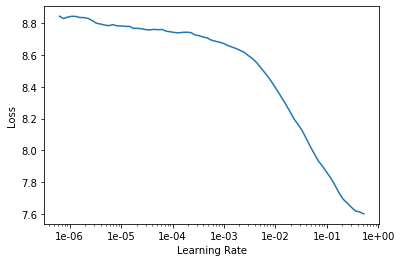

In [13]:
learn_lm.recorder.plot(skip_end=15)

In [14]:
learn_lm.fit_one_cycle(2, 7e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.175366,2.192279,0.542857,12:40
1,5.254408,1.621416,0.685714,12:43


In [15]:
learn_lm.save('fit_head-KED-prep')

In [ ]:
learn_lm.load('fit_head-KED-prep')

In [17]:
learn=learn_lm
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


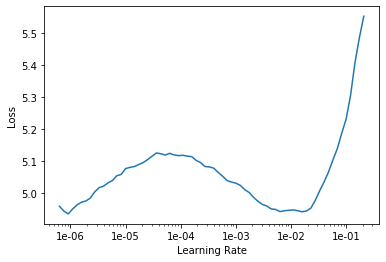

In [18]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [19]:
epochs = 7 # orig: 10
learn.fit_one_cycle(epochs, slice(2e-4, 2e-3) , moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.490099,1.076693,0.757143,14:13
1,4.158804,0.982657,0.785714,14:13
2,3.888828,0.936499,0.800000,14:14
3,3.904911,0.755673,0.842857,14:15
4,3.827478,0.750339,0.814286,14:14
5,3.801795,0.691132,0.828571,14:14
6,3.718056,0.691283,0.814286,14:13


In [20]:
learn.save('fine_tuned-KED-prep')

In [21]:

learn.load('fine_tuned-KED-prep');

In [22]:
# test lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 5
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


The European Commission council examination community policy towards integration territory community member state principle community basis < reference > treaty community treaty community whereas community advantage member state develop country trade area community < date > economy competitiveness community country world trade organization
The European Commission community treaty community regard treaty energy community < reference > thereof whereas community member state principle resolution promote cooperation commission communication field promote application community < reference > treaty community whereas community institution effect whereas community level protection community level
The European Commission community treaty council < date > < reference > treaty community regard commission decision < date > concern accession community protocol accession austria finland union < reference > act accession < reference > thereof regard proposal commission < reference >
The European Comm

In [23]:
learn.save_encoder('fine_tuned_enc-KED-prep')


## Train a classifier

As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

In [5]:
def my_prc(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def my_rec(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

thresh=0.001
acc_0001 = partial(accuracy_thresh, thresh=thresh)
prc_0001 = partial(my_prc, thresh=thresh)
rec_0001 = partial(my_rec, thresh=thresh)
f_0001 = partial(fbeta, thresh=thresh, beta=1)


thresh=0.01
acc_001 = partial(accuracy_thresh, thresh=thresh)
prc_001 = partial(my_prc, thresh=thresh)
rec_001 = partial(my_rec, thresh=thresh)
f_001 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.05
acc_005 = partial(accuracy_thresh, thresh=thresh)
prc_005 = partial(my_prc, thresh=thresh)
rec_005 = partial(my_rec, thresh=thresh)
f_005 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.1
acc_01 = partial(accuracy_thresh, thresh=thresh)
prc_01 = partial(my_prc, thresh=thresh)
rec_01 = partial(my_rec, thresh=thresh)
f_01 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
prc_02 = partial(my_prc, thresh=thresh)
rec_02 = partial(my_rec, thresh=thresh)
f_02 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.3
acc_03 = partial(accuracy_thresh, thresh=thresh)
prc_03 = partial(my_prc, thresh=thresh)
rec_03 = partial(my_rec, thresh=thresh)
f_03 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.4
acc_04 = partial(accuracy_thresh, thresh=thresh)
prc_04 = partial(my_prc, thresh=thresh)
rec_04 = partial(my_rec, thresh=thresh)
f_04 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.5
acc_05 = partial(accuracy_thresh, thresh=thresh)
prc_05 = partial(my_prc, thresh=thresh)
rec_05 = partial(my_rec, thresh=thresh)
f_05 = partial(fbeta, thresh=thresh, beta=1)


In [25]:
## make small subsample in order to train faster
df = pd.read_csv(FN)
df = df[['text','labels']]
df.head(2)


,text,labels
0,council <legalact> euratom guarantee fund acti...,1052;1130;1164;2300;2609;4838
1,council decision <date> adjusting amount devel...,197;665;922;1087;4055;5083


In [26]:
data_clas = (TextList.from_csv(Path('.'), FN, vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=';')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [27]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

60000
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '>', '<', 'reference', 'date', 'legalact', 'commission', 'state', 'member', 'community', 'product', 'decision']


In [3]:
data_clas = load_data(Path('.'), 'data_clas.pkl', bs=bs)

In [29]:
_, class_counts = np.unique(data_clas.y.items, return_counts=True)
len(class_counts)


13623

In [30]:
data_clas.show_batch()
#data_clas.label_list


text,target
xxbos council < legalact > < date > approximation law member state regard transport road council union regard treaty community < reference > thereof regard proposal commission regard opinion committee act accordance procedure < reference > treaty year transport road event accident member state ireland contract party agreement concern carriage road adr scope community rule transport road whereas rule traffic order harmonize community condition transport road community legislation embrace range,1638;2897;3681;4033;4521;4533
xxbos commission < legalact > ec accounting accordance < legalact > ec parliament council eea relevance commission community treaty community < legalact > ec parliament council < date > application accounting standard particular < reference > thereof whereas < legalact > ec year start < date > company law member state condition prepare account conformity accounting define < reference > < legalact > commission advice provide committee accounting standard existence,3647;5156;54
xxbos parliament council < date > threewheel motor vehicle parliament council union regard treaty community < reference > a thereof regard proposal commission regard opinion committee act accordance procedure < reference > b treaty text conciliation committee < date > measure operation market member state threewheel motor vehicle cover < legalact > requirement member state whereas difference requirement constitute barrier trade community whereas operation market requirement member state place <,1252;4653;468;469;5235;5593
xxbos commission decision < date > declare concentration market agreement case iv mexxon mobil document number text eea relevance ec commission community treaty community agreement area < reference > thereof regard council < legalact > eec concentration undertaking < legalact > ec particular < reference > commission decision < date > initiate case undertaking concern opportunity view objection commission opinion committee concentration commission notification concentration xxup -pron- undertaking exxon corporation,1362;1411;1414;183;616;69;747
xxbos commission decision < date > relate proceed < reference > ec treaty < reference > eea agreement case e - vitamin document number dutch text eea relevance ec commission community treaty community agreement area regard council < legalact > < date > < reference > treaty < legalact > ec < reference > commission decision < date > initiate case undertaking concern opportunity view objection commission < reference >,1415;1432;1549;3821;4733;5267;539


In [6]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
#learn.metrics = [accuracy_thresh, custom_precision, custom_recall, 
#                 acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03 ]
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05 ]
#!mv *pth models
learn.load_encoder('fine_tuned_enc-KED-prep')


In [7]:
print(learn.loss_func)
print(learn.loss_func.func)

FlattenedLoss of BCEWithLogitsLoss()
BCEWithLogitsLoss()


In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


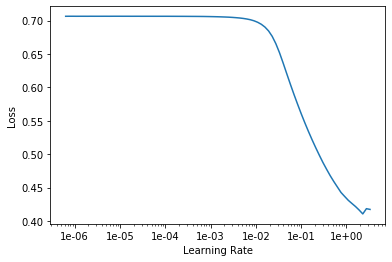

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(2, slice(1e-1,1e-1), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.008317,0.007660,0.998559,0.853650,0.358938,0.057333,0.017824,0.974394,0.358954,0.056940,0.067543,0.994695,0.363783,0.055650,0.150740,0.997054,0.369437,0.053720,0.167997,0.998088,0.381220,0.050298,0.148260,0.998378,0.384757,0.046000,0.119261,0.998503,0.387790,0.042794,0.095125,0.998559,0.396575,0.040061,0.073688,06:29
1,0.006264,0.005529,0.998716,0.892695,0.679548,0.137088,0.027976,0.983663,0.679978,0.136207,0.123308,0.996210,0.688328,0.132098,0.281882,0.997795,0.697271,0.127860,0.329044,0.998491,0.708992,0.119968,0.319146,0.998658,0.722210,0.110686,0.274396,0.998702,0.738509,0.103231,0.224977,0.998716,0.747578,0.094661,0.186958,06:21


In [36]:
learn.save('first-2nd')

In [37]:
learn.load('first-2nd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15613 items)
x: TextList
xxbos council < legalact > euratom guarantee fund action council union regard treaty community < reference > thereof regard treaty energy community < reference > thereof regard proposal commission regard opinion parliament opinion court auditor budget community increase risk result guarantee cover loan country council < date > conclude consideration prudent management discipline call mechanism fund set order cover risk loan guarantee cover loan country project country meet guarantee fund communitys creditor institution agree agreement < date > enter budget reserve relate lending guarantee operation country mechanism guarantee draw cash resource < reference > council < legalact > euratom decision eec euratom system community resource guarantee fund constitute payment resource whereas fund interest resource amount recover default debtor fund guarantee whereas reference practice institution ratio % guarantee fu

Why gradual unfreeze? Give example of Image detection.

In [38]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


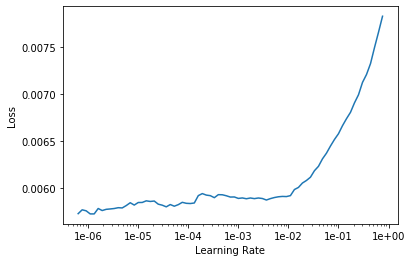

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(4, slice(3e-3/(2.6**4),3e-3), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.006013,0.006047,0.998648,0.869615,0.631141,0.030528,0.021126,0.986283,0.633872,0.029997,0.128848,0.997563,0.607915,0.028864,0.289585,0.998450,0.600753,0.026839,0.266141,0.998664,0.586506,0.023656,0.171450,0.998677,0.558160,0.020792,0.110868,0.998662,0.525833,0.018510,0.071829,0.998648,0.507766,0.016254,0.044881,05:49
1,0.005848,0.005386,0.998719,0.885656,0.732111,0.121943,0.027963,0.983514,0.732773,0.121129,0.126754,0.996576,0.739317,0.117226,0.305409,0.998006,0.754385,0.114015,0.345710,0.998584,0.759852,0.106939,0.316120,0.998701,0.771409,0.099727,0.263447,0.998726,0.771361,0.093092,0.214764,0.998719,0.770669,0.086353,0.169231,06:05
2,0.005468,0.005948,0.998596,0.913596,0.689869,0.178616,0.035946,0.985154,0.691518,0.177929,0.143469,0.996138,0.698089,0.174296,0.317661,0.997617,0.704527,0.170166,0.370345,0.998323,0.718741,0.160210,0.368208,0.998511,0.732436,0.150351,0.330021,0.998573,0.742552,0.141684,0.284220,0.998596,0.756992,0.134164,0.238469,06:15
3,0.005194,0.005051,0.998758,0.906763,0.724796,0.168962,0.032582,0.984899,0.725531,0.167849,0.138046,0.996446,0.729940,0.163202,0.319245,0.997915,0.738825,0.157981,0.372339,0.998573,0.753190,0.147864,0.364286,0.998720,0.770301,0.138959,0.323249,0.998757,0.785557,0.129600,0.275838,0.998758,0.794959,0.121267,0.228390,06:31


In [41]:
learn.save('second-2nd')

In [42]:
learn.load('second-2nd');

In [43]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


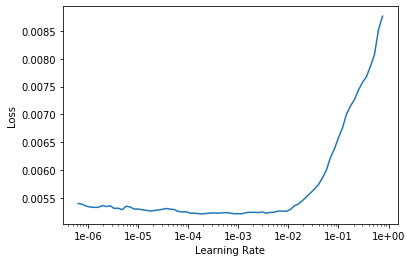

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
#learn.fit_one_cycle(4, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
learn.fit_one_cycle(8, slice(4e-3/(2.6**4),4e-3), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.005365,0.004982,0.998769,0.906915,0.702126,0.191335,0.035709,0.984413,0.705003,0.190368,0.142960,0.996252,0.712628,0.186928,0.319029,0.997825,0.719481,0.180710,0.378130,0.998538,0.737226,0.170785,0.382075,0.998719,0.750237,0.160348,0.348842,0.998764,0.766192,0.151871,0.300958,0.998769,0.779755,0.142970,0.252864,08:59
1,0.005408,0.005195,0.998741,0.924789,0.702628,0.168197,0.045035,0.987675,0.704252,0.167369,0.172031,0.996900,0.707554,0.163339,0.337039,0.998086,0.713769,0.158663,0.371600,0.998583,0.729874,0.150468,0.348310,0.998702,0.744961,0.142832,0.307894,0.998735,0.757380,0.134193,0.264952,0.998741,0.774714,0.126509,0.223594,08:14
2,0.005533,0.005034,0.998772,0.922868,0.689125,0.215387,0.046970,0.986651,0.689699,0.214598,0.165000,0.996521,0.694891,0.210947,0.330608,0.997916,0.700268,0.205386,0.383841,0.998543,0.711127,0.195656,0.381083,0.998705,0.719061,0.184884,0.351271,0.998759,0.728873,0.175878,0.313424,0.998772,0.739846,0.167609,0.275997,06:57
3,0.005277,0.004883,0.998800,0.933249,0.707027,0.226702,0.050649,0.988108,0.708839,0.225777,0.179595,0.996802,0.714992,0.221205,0.350630,0.998028,0.718899,0.214835,0.400995,0.998591,0.733264,0.203027,0.400845,0.998736,0.744012,0.193252,0.372304,0.998790,0.756672,0.181884,0.337924,0.998800,0.767849,0.173610,0.296560,08:10
4,0.004901,0.004680,0.998828,0.929784,0.738208,0.242655,0.045163,0.987725,0.738589,0.241254,0.173719,0.996744,0.745713,0.236340,0.355477,0.998016,0.752192,0.231386,0.414174,0.998621,0.763418,0.220433,0.422215,0.998773,0.775517,0.208685,0.395358,0.998822,0.787499,0.197567,0.357502,0.998828,0.798158,0.186518,0.314530,07:56
5,0.004650,0.004528,0.998842,0.927825,0.717947,0.270415,0.043687,0.987020,0.718814,0.269485,0.169268,0.996493,0.724165,0.263589,0.352070,0.997895,0.731653,0.256905,0.418688,0.998579,0.744352,0.243101,0.440474,0.998770,0.758288,0.232039,0.422876,0.998831,0.771292,0.220927,0.388181,0.998842,0.781933,0.209399,0.344443,07:40
6,0.004596,0.004445,0.998862,0.935814,0.752277,0.267795,0.048329,0.988468,0.753096,0.266632,0.184164,0.996842,0.760361,0.261764,0.371646,0.998071,0.766395,0.254903,0.435617,0.998659,0.780735,0.242804,0.451409,0.998815,0.792843,0.230937,0.428529,0.998861,0.806555,0.220014,0.392388,0.998862,0.821490,0.209670,0.348086,07:24
7,0.004356,0.004432,0.998864,0.935047,0.737971,0.278742,0.048258,0.988088,0.739650,0.277491,0.181818,0.996721,0.745406,0.273067,0.367686,0.998007,0.752995,0.267497,0.433231,0.998637,0.767423,0.254115,0.456853,0.998802,0.780825,0.243421,0.435414,0.998856,0.794064,0.231289,0.401276,0.998864,0.805703,0.219651,0.359810,07:49


In [46]:
learn.save('third-2nd')

In [8]:
learn.load('third-2nd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15613 items)
x: TextList
xxbos council < legalact > euratom guarantee fund action council union regard treaty community < reference > thereof regard treaty energy community < reference > thereof regard proposal commission regard opinion parliament opinion court auditor budget community increase risk result guarantee cover loan country council < date > conclude consideration prudent management discipline call mechanism fund set order cover risk loan guarantee cover loan country project country meet guarantee fund communitys creditor institution agree agreement < date > enter budget reserve relate lending guarantee operation country mechanism guarantee draw cash resource < reference > council < legalact > euratom decision eec euratom system community resource guarantee fund constitute payment resource whereas fund interest resource amount recover default debtor fund guarantee whereas reference practice institution ratio % guarantee fu

In [9]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


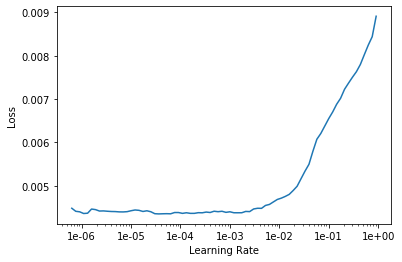

In [49]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), wd=0.1) 

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.004385,0.004428,0.998862,0.936185,0.740408,0.277043,0.050340,0.988376,0.741370,0.276074,0.185270,0.996776,0.749682,0.270661,0.370508,0.998038,0.756640,0.264703,0.436805,0.998642,0.768391,0.252643,0.455523,0.998806,0.783734,0.242177,0.436073,0.998859,0.796367,0.228856,0.399921,0.998862,0.808133,0.216197,0.356523,08:52
1,0.004462,0.004433,0.998869,0.939452,0.747471,0.278252,0.053347,0.988850,0.748395,0.276910,0.190774,0.996880,0.753159,0.272368,0.376162,0.998082,0.756583,0.265578,0.439833,0.998662,0.769152,0.253963,0.458421,0.998815,0.782442,0.243465,0.434905,0.998864,0.792942,0.231541,0.399314,0.998869,0.806770,0.219380,0.358226,08:59
2,0.004565,0.004430,0.998865,0.944106,0.738549,0.282979,0.058704,0.989385,0.739583,0.281410,0.199317,0.996914,0.743820,0.275239,0.378844,0.998100,0.749556,0.270506,0.443039,0.998659,0.761582,0.258067,0.458694,0.998807,0.774114,0.247915,0.436065,0.998857,0.783536,0.236750,0.402165,0.998865,0.797164,0.226419,0.361290,08:06
3,0.004479,0.004408,0.998872,0.939380,0.758893,0.271964,0.055613,0.988969,0.759763,0.270625,0.196588,0.996945,0.767416,0.265394,0.384172,0.998127,0.773018,0.258872,0.448006,0.998682,0.786922,0.247496,0.459788,0.998820,0.799331,0.236029,0.431930,0.998868,0.813565,0.224290,0.397327,0.998872,0.825465,0.213561,0.352785,09:31
4,0.004440,0.004383,0.998876,0.942449,0.730341,0.299110,0.057753,0.989079,0.731269,0.298286,0.198212,0.996831,0.736867,0.293776,0.381657,0.998032,0.744094,0.288216,0.444344,0.998640,0.757079,0.276684,0.465944,0.998799,0.767153,0.264616,0.444359,0.998861,0.779048,0.253262,0.416107,0.998876,0.788876,0.241234,0.377369,08:32
5,0.004376,0.004346,0.998882,0.945079,0.756910,0.285306,0.057187,0.989822,0.757531,0.284166,0.206147,0.997061,0.761652,0.278897,0.393126,0.998162,0.768776,0.272394,0.454869,0.998694,0.781670,0.261008,0.470362,0.998832,0.792957,0.248954,0.445741,0.998876,0.806447,0.238314,0.409975,0.998882,0.815990,0.226963,0.369025,09:30
6,0.004289,0.004312,0.998887,0.937530,0.765004,0.284748,0.050976,0.988837,0.765315,0.282845,0.193762,0.996935,0.770687,0.278262,0.386447,0.998141,0.779101,0.272839,0.454266,0.998707,0.791298,0.259751,0.474144,0.998847,0.803450,0.248511,0.449211,0.998888,0.816238,0.236456,0.413641,0.998887,0.826767,0.224612,0.367235,09:43
7,0.004092,0.004277,0.998892,0.936213,0.758626,0.291980,0.050445,0.988672,0.759515,0.290817,0.193586,0.996893,0.763583,0.286082,0.387463,0.998119,0.773995,0.279767,0.456688,0.998700,0.786349,0.266285,0.477525,0.998847,0.803488,0.253769,0.455612,0.998892,0.814948,0.242549,0.420081,0.998892,0.824415,0.230944,0.376198,08:00
8,0.004137,0.004273,0.998893,0.941947,0.751071,0.298814,0.054582,0.989343,0.752228,0.297797,0.201165,0.996966,0.757442,0.292956,0.391546,0.998133,0.763306,0.286934,0.459333,0.998699,0.779263,0.275572,0.480040,0.998852,0.797448,0.262875,0.460223,0.998891,0.807831,0.250926,0.425290,0.998893,0.816735,0.239354,0.382945,09:11
9,0.004110,0.004272,0.998892,0.941501,0.760424,0.291072,0.053788,0.989411,0.761552,0.289817,0.201670,0.997012,0.767837,0.284536,0.393788,0.998164,0.776333,0.278554,0.460507,0.998711,0.792466,0.265683,0.477996,0.998854,0.804049,0.254568,0.455216,0.998891,0.815320,0.243053,0.419275,0.998892,0.824933,0.232513,0.375393,07:44


In [11]:
learn.save('forth-2nd')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


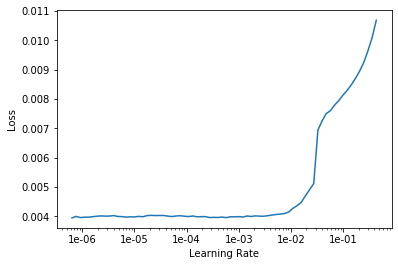

In [20]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), wd=0.1) 

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.004103,0.004271,0.998892,0.939201,0.759664,0.291610,0.052882,0.989113,0.760478,0.290871,0.198956,0.996966,0.765327,0.284925,0.391545,0.998150,0.771339,0.277637,0.460547,0.998710,0.789690,0.266245,0.479179,0.998855,0.803509,0.254365,0.458089,0.998893,0.815878,0.242765,0.421466,0.998892,0.826888,0.231863,0.375580,07:58
1,0.004244,0.004336,0.998882,0.943176,0.747825,0.290694,0.057814,0.989498,0.749312,0.290009,0.205352,0.997017,0.752331,0.284905,0.391479,0.998161,0.761725,0.279069,0.455927,0.998699,0.773692,0.267699,0.472968,0.998836,0.785930,0.255705,0.448283,0.998882,0.798108,0.244025,0.416088,0.998882,0.808183,0.233480,0.372385,07:26
2,0.004325,0.004341,0.998883,0.943759,0.751661,0.287591,0.057592,0.989665,0.752968,0.286904,0.207471,0.997047,0.758730,0.281758,0.394465,0.998151,0.763988,0.275383,0.457115,0.998690,0.778521,0.263940,0.471020,0.998834,0.788454,0.251921,0.448162,0.998878,0.798931,0.239923,0.411819,0.998883,0.812487,0.228917,0.370542,09:56
3,0.004302,0.004321,0.998890,0.940172,0.751272,0.294945,0.055375,0.989031,0.752693,0.293883,0.200679,0.996914,0.757675,0.288517,0.388591,0.998106,0.765512,0.282006,0.455375,0.998682,0.778761,0.269924,0.473495,0.998835,0.790409,0.258017,0.453432,0.998885,0.799363,0.247011,0.419382,0.998890,0.809479,0.235730,0.378153,08:15
4,0.004239,0.004302,0.998891,0.939861,0.760976,0.290891,0.051098,0.989440,0.762658,0.289695,0.199558,0.997098,0.766955,0.284373,0.396687,0.998209,0.771479,0.278147,0.462283,0.998733,0.783346,0.264891,0.477085,0.998858,0.801116,0.253558,0.452936,0.998893,0.810527,0.242043,0.416310,0.998891,0.821648,0.229297,0.371867,08:52
5,0.004204,0.004275,0.998896,0.943627,0.751662,0.302787,0.054543,0.989727,0.753150,0.301494,0.204354,0.997064,0.758974,0.297108,0.394842,0.998165,0.763070,0.290082,0.459367,0.998702,0.780835,0.278804,0.476579,0.998848,0.791659,0.268836,0.457231,0.998894,0.803050,0.256422,0.425660,0.998896,0.814316,0.244275,0.383042,09:40
6,0.004050,0.004228,0.998900,0.939231,0.758742,0.299979,0.052006,0.989153,0.760192,0.298662,0.200178,0.996995,0.765424,0.294071,0.397858,0.998156,0.772285,0.287525,0.466073,0.998716,0.782327,0.275438,0.486158,0.998859,0.798453,0.262707,0.464215,0.998898,0.810964,0.251799,0.428324,0.998900,0.822219,0.240393,0.384762,08:10
7,0.004044,0.004210,0.998906,0.942944,0.762714,0.304471,0.054703,0.989700,0.764279,0.303354,0.206792,0.997100,0.769782,0.297862,0.403754,0.998188,0.776199,0.291970,0.469483,0.998728,0.788110,0.279563,0.488268,0.998870,0.799519,0.266725,0.468953,0.998906,0.810821,0.255546,0.433381,0.998906,0.822148,0.243774,0.389350,09:13
8,0.003918,0.004204,0.998910,0.945317,0.758617,0.310129,0.056252,0.989989,0.762341,0.308590,0.209305,0.997135,0.767102,0.303512,0.405262,0.998201,0.776456,0.296203,0.470998,0.998732,0.790228,0.284101,0.490786,0.998867,0.798331,0.272931,0.469773,0.998907,0.810872,0.261181,0.436504,0.998910,0.822078,0.249462,0.394482,08:24
9,0.003874,0.004188,0.998912,0.939477,0.769425,0.307617,0.051285,0.989235,0.770734,0.306652,0.199832,0.997016,0.774454,0.300765,0.399248,0.998173,0.779013,0.295188,0.471336,0.998727,0.789334,0.282618,0.491755,0.998871,0.801090,0.269902,0.470951,0.998909,0.810838,0.258423,0.436719,0.998912,0.822563,0.247594,0.393307,07:39


In [29]:
learn.save('final-2nd')

## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [30]:
learn.load('final-2nd')

# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()

In [31]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

In [38]:
thresh = 0.20

print("F1 (micro)", f1_score(y_true, y_pred>thresh, average='micro'))
print("P (micro)", precision_score(y_true, y_pred>thresh, average='micro'))
print("R (micro)", recall_score(y_true, y_pred>thresh, average='micro'))

print("\nF1 (macro)", f1_score(y_true, y_pred>thresh, average='macro'))
print("P (macro)", precision_score(y_true, y_pred>thresh, average='macro'))
print("R (macro) ", recall_score(y_true, y_pred>thresh, average='macro'))


F1 (micro) 0.5160863367949501
P (micro) 0.5446438164822177
R (micro) 0.4903743832833511

F1 (macro) 0.14855665962386025
P (macro) 0.16534837802397476
R (macro)  0.15587170758845229


In [34]:
f1_score(y_true, y_pred>thresh, average='macro')

0.14362761048543862

In [35]:
y_true_n = y_true.numpy()
scores = y_pred.numpy()
scores.shape, y_true_n.shape

((3903, 3825), (3903, 3825))

In [36]:
## precision at k
def tmp_precision(actual, predicted):
    #print(predicted)
    actual_one = np.where(actual == 1)[0]
    #print(actual_one)
    #print(type(actual_one))
    
    act_set = set(list(actual_one))
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def tmp_recall(actual, predicted):
    actual_one = np.where(actual == 1)[0]
    
    act_set = set(actual_one)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

## sort indizes in descending order
scores_idx_sorted = (-scores).argsort() 
    
#print(precs)
for i in range(7):
    k = i+1
    
    precs, recas = [], []
    for i in range(len(y_true_n)):
        precs.append( tmp_precision(y_true_n[i], scores_idx_sorted[i]) )
        recas.append( tmp_recall(y_true_n[i], scores_idx_sorted[i]) )
    
    print("Precision at: %d:   " % (k,), sum(precs)/len(precs))
    print("Recall at: %d:   " % (k,), sum(recas)/len(recas))
    print()


Precision at: 1:    0.7776069689982065
Recall at: 1:    0.15627632608800948

Precision at: 2:    0.6977965667435306
Recall at: 2:    0.2767690354738794

Precision at: 3:    0.6302843966179861
Recall at: 3:    0.3704005391937758

Precision at: 4:    0.5694978221880604
Recall at: 4:    0.44260914662528855

Precision at: 5:    0.5164232641557759
Recall at: 5:    0.49922331916951307

Precision at: 6:    0.4669057989580659
Recall at: 6:    0.5397786103781472

Precision at: 7:    0.42626551004721175
Recall at: 7:    0.5731666616754983



In [21]:

n_classes = len(data_clas.valid_ds.classes)
Y_test = y_true.numpy()
y_score = y_pred.numpy()

## from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.59


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.59')

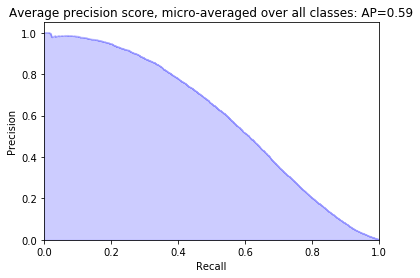

In [23]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [24]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

ValueError: Image size of 449x71271 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 504x576 with 1 Axes>

((3503, 3391), (3503, 3391))

In [12]:
metrics = classification_report(y_true_n, scores>thresh, target_names=data_clas.valid_ds.classes)
print(metrics)

              precision    recall  f1-score   support

          10       0.00      0.00      0.00         1
        1000       0.00      0.00      0.00         4
        1004       0.00      0.00      0.00         0
        1005       0.50      0.45      0.48        42
        1008       0.00      0.00      0.00         0
        1010       0.00      0.00      0.00         0
        1011       0.00      0.00      0.00         0
        1012       0.00      0.00      0.00         1
        1015       0.60      0.50      0.55         6
        1018       0.55      0.60      0.57        10
        1019       0.74      0.71      0.73        28
        1021       0.60      0.55      0.57        11
        1025       0.00      0.00      0.00         1
        1026       0.50      1.00      0.67         2
        1031       0.75      0.43      0.55         7
        1033       0.00      0.00      0.00         1
        1034       0.00      0.00      0.00         2
        1035       1.00    

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
